## Librerías

In [28]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics

# Funciones

In [2]:
# Data Preprocessing
def preprocessor(data):
    data = data.sort_values(by=['Customer_ID', 'Month'])
    # Encoding categorical values
    categorical_columns = [cname for cname in data.columns if data[cname].nunique() and data[cname].dtype == "object"]
    categorical_columns = categorical_columns[1:]
    ordinal_encoder = OrdinalEncoder()
    data[categorical_columns] = ordinal_encoder.fit_transform(data[categorical_columns])
    return data

In [3]:
def client_summary(data, target_month, num_prev_months):
    months = [1, 2, 3, 4, 5, 6, 7, 8]
    start_index = months.index(target_month) - num_prev_months
    start_index = max(0, start_index)
    previous_months = months[start_index:months.index(target_month)]

    agg_data = data[data['Month'].between(previous_months[0], previous_months[-1], inclusive='both')].groupby('Customer_ID').agg({
        'Age'                      :'mean',
        'Occupation'               :'first',
        'Annual_Income'            :'mean',
        'Monthly_Inhand_Salary'    :'mean',
        'Num_Bank_Accounts'        :'mean',
        'Num_Credit_Card'          :'mean',
        'Interest_Rate'            :'mean',
        'Num_of_Loan'              :'mean',
        'Type_of_Loan'             :'first',
        'Delay_from_due_date'      :'mean',
        'Num_of_Delayed_Payment'   :'mean',
        'Changed_Credit_Limit'     :'mean',
        'Num_Credit_Inquiries'     :'mean',
        'Credit_Mix'               :'first',
        'Outstanding_Debt'         :'mean',
        'Credit_Utilization_Ratio' :'mean',
        'Credit_History_Age'       :'mean',
        #'Payment_of_Min_Amount'    :'first',
        'Total_EMI_per_month'      :'mean',
        'Amount_invested_monthly'  :'mean',
        #'Payment_Behaviour'        :'first',
        'Monthly_Balance'          :'mean',
        'Credit_Score'             : list   # List of credit scores for months 1 to 7
    }).reset_index()


    # Expand the list of credit scores into separate columns
    expanded_scores = agg_data['Credit_Score'].apply(pd.Series)
    expanded_scores.columns = [f'Credit_Score_{i}' for i in previous_months]
    agg_data = pd.concat([agg_data, expanded_scores], axis=1)
    agg_data.drop('Credit_Score', axis=1, inplace=True)

    # Target variable
    target_month_data = data[data['Month'] == target_month]
    target_month_data = target_month_data[["Customer_ID", "Credit_Score"]].rename(columns={'Credit_Score': 'Target_Score'})

    # Merge data and target
    agg_data = agg_data.merge(target_month_data, on="Customer_ID", how="inner")

    return agg_data

In [4]:
# Split the data
def split_data(df, random_state, test_size):
    X = df.drop(['Customer_ID', 'Target_Score'], axis=1)
    y = df['Target_Score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [5]:
# Model building
def test_model(X_train, y_train, X_test, clf):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf),
    ])
    pipeline.set_params(**clf.best_params_)
    pipeline.fit(X_train, y_train)

    # Prediction
    y_pred = pipeline.predict(X_test)
    return y_pred

# Lectura del dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')
# Read dataset
data = pd.read_csv("/content/drive/MyDrive/Universidad/Semestre 9/ML aplicado/Anteproyecto/train.csv")
# Data processing
data = preprocessor(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prueba con diferentes modelo y diferentes cantidades de meses previos

In [7]:
# Parameters
random_state = 42
test_size = 0.2
target_month = 8
# Save models predictions
models = []

### Funciones para pruebas de modelos con diferentes parametros

In [8]:
# Definition of parameters grid
param_grid_knn = {
    'classifier__metric': ['minkowski', 'euclidean'],
    'classifier__n_neighbors': list(range(1, 100))
}
param_grid_rf_gb = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': list(range(6, 10)),
    'classifier__min_samples_leaf': [10, 300, 2000]
}

In [9]:
# Evaluate different parameters
def best_parameters(param_grid, classifier):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', classifier),
    ])
    clf = GridSearchCV(pipeline, cv=3, param_grid=param_grid)
    clf.fit(X_train, y_train)
    return clf

In [10]:
# Print different model metrics
def print_metrics(y_test, y_pred):
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1_score)
    print('More info:')
    print(classification_report(y_test, y_pred))
    print()

In [11]:
# Predict data
def model_prediction(months, name, model, X_test):
    print(f'{name} USING THE LAST {months} MONTHS DATA\n')
    y_pred = model.predict(X_test)
    print_metrics(y_test, y_pred)
    return y_pred

### Prueba usando los tres meses anteriores

In [12]:
# New datasets
months=3
df = client_summary(data=data, target_month=target_month, num_prev_months=months)
X_train, X_test, y_train, y_test = split_data(df=df, random_state=random_state, test_size=test_size)

In [13]:
# Get best parameters
clf = best_parameters(param_grid_knn, KNeighborsClassifier())
y_pred_knn = model_prediction(months, 'KNN', clf, X_test)
print('Best parameters:\n', clf.best_params_)

KNN USING THE LAST 3 MONTHS DATA

Accuracy: 0.8
Precision: 0.8024775194781423
Recall: 0.8
F1-score: 0.8005733945978902
More info:
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       500
         1.0       0.74      0.81      0.77       715
         2.0       0.83      0.79      0.81      1285

    accuracy                           0.80      2500
   macro avg       0.80      0.80      0.80      2500
weighted avg       0.80      0.80      0.80      2500


Best parameters:
 {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 21}


In [14]:
# Get best parameters
clf = best_parameters(param_grid_rf_gb, RandomForestClassifier(random_state=random_state))
y_pred_rf = model_prediction(months, 'RANDOM FOREST', clf, X_test)
print('Best parameters:\n', clf.best_params_)

RANDOM FOREST USING THE LAST 3 MONTHS DATA

Accuracy: 0.8584
Precision: 0.8592880741141921
Recall: 0.8584
F1-score: 0.858406212819225
More info:
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85       500
         1.0       0.84      0.89      0.86       715
         2.0       0.88      0.84      0.86      1285

    accuracy                           0.86      2500
   macro avg       0.85      0.86      0.86      2500
weighted avg       0.86      0.86      0.86      2500


Best parameters:
 {'classifier__max_depth': 9, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}


In [15]:
# Get best parameters
clf = best_parameters(param_grid_rf_gb, GradientBoostingClassifier(random_state=random_state))
y_pred_gb = model_prediction(months, 'GRADIENT BOOSTING', clf, X_test)
print('Best parameters:\n', clf.best_params_)

GRADIENT BOOSTING USING THE LAST 3 MONTHS DATA

Accuracy: 0.8556
Precision: 0.856705952700715
Recall: 0.8556
F1-score: 0.8555921437762969
More info:
              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       500
         1.0       0.83      0.89      0.86       715
         2.0       0.88      0.84      0.86      1285

    accuracy                           0.86      2500
   macro avg       0.85      0.86      0.85      2500
weighted avg       0.86      0.86      0.86      2500


Best parameters:
 {'classifier__max_depth': 6, 'classifier__min_samples_leaf': 300, 'classifier__n_estimators': 50}


In [16]:
models.append([y_pred_knn, y_pred_rf, y_pred_gb])

### Prueba usando los cinco meses anteriores

In [17]:
# New datasets
months=5
df = client_summary(data=data, target_month=target_month, num_prev_months=months)
X_train, X_test, y_train, y_test = split_data(df=df, random_state=random_state, test_size=test_size)

In [18]:
# Get best parameters
clf = best_parameters(param_grid_knn, KNeighborsClassifier())
y_pred_knn = model_prediction(months, 'KNN', clf, X_test)
print('Best parameters:\n', clf.best_params_)

KNN USING THE LAST 5 MONTHS DATA

Accuracy: 0.8016
Precision: 0.8075592051247901
Recall: 0.8016
F1-score: 0.8020650124894168
More info:
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82       500
         1.0       0.73      0.85      0.78       715
         2.0       0.85      0.76      0.80      1285

    accuracy                           0.80      2500
   macro avg       0.80      0.82      0.80      2500
weighted avg       0.81      0.80      0.80      2500


Best parameters:
 {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 6}


In [19]:
# Get best parameters
clf = best_parameters(param_grid_rf_gb, RandomForestClassifier(random_state=random_state))
y_pred_rf = model_prediction(months, 'RANDOM FOREST', clf, X_test)
print('Best parameters:\n', clf.best_params_)

RANDOM FOREST USING THE LAST 5 MONTHS DATA

Accuracy: 0.8536
Precision: 0.8551508977285699
Recall: 0.8536
F1-score: 0.85359446799152
More info:
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       500
         1.0       0.83      0.89      0.86       715
         2.0       0.88      0.83      0.85      1285

    accuracy                           0.85      2500
   macro avg       0.85      0.86      0.85      2500
weighted avg       0.86      0.85      0.85      2500


Best parameters:
 {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}


In [20]:
# Get best parameters
clf = best_parameters(param_grid_rf_gb, GradientBoostingClassifier(random_state=random_state))
y_pred_gb = model_prediction(months, 'GRADIENT BOOSTING', clf, X_test)
print('Best parameters:\n', clf.best_params_)

GRADIENT BOOSTING USING THE LAST 5 MONTHS DATA

Accuracy: 0.8492
Precision: 0.8513144771929375
Recall: 0.8492
F1-score: 0.8491336889704518
More info:
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84       500
         1.0       0.82      0.89      0.85       715
         2.0       0.88      0.82      0.85      1285

    accuracy                           0.85      2500
   macro avg       0.84      0.86      0.85      2500
weighted avg       0.85      0.85      0.85      2500


Best parameters:
 {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 300, 'classifier__n_estimators': 50}


In [21]:
models.append([y_pred_knn, y_pred_rf, y_pred_gb])

### Prueba usando los siete meses anteriores

In [22]:
# New datasets
months=7
df = client_summary(data=data, target_month=target_month, num_prev_months=months)
X_train, X_test, y_train, y_test = split_data(df=df, random_state=random_state, test_size=test_size)

In [23]:
# Get best parameters
clf = best_parameters(param_grid_knn, KNeighborsClassifier())
y_pred_knn = model_prediction(months, 'KNN', clf, X_test)
print('Best parameters:\n', clf.best_params_)

KNN USING THE LAST 7 MONTHS DATA

Accuracy: 0.794
Precision: 0.8016328024512175
Recall: 0.794
F1-score: 0.7943244450711034
More info:
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83       500
         1.0       0.71      0.84      0.77       715
         2.0       0.85      0.74      0.79      1285

    accuracy                           0.79      2500
   macro avg       0.79      0.81      0.80      2500
weighted avg       0.80      0.79      0.79      2500


Best parameters:
 {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 8}


In [24]:
# Get best parameters
clf = best_parameters(param_grid_rf_gb, RandomForestClassifier(random_state=random_state))
y_pred_rf = model_prediction(months, 'RANDOM FOREST', clf, X_test)
print('Best parameters:\n', clf.best_params_)

RANDOM FOREST USING THE LAST 7 MONTHS DATA

Accuracy: 0.852
Precision: 0.8558828094332215
Recall: 0.852
F1-score: 0.8518427274831233
More info:
              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       500
         1.0       0.81      0.91      0.86       715
         2.0       0.89      0.81      0.85      1285

    accuracy                           0.85      2500
   macro avg       0.84      0.87      0.85      2500
weighted avg       0.86      0.85      0.85      2500


Best parameters:
 {'classifier__max_depth': 9, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}


In [25]:
# Get best parameters
clf = best_parameters(param_grid_rf_gb, GradientBoostingClassifier(random_state=random_state))
y_pred_gb = model_prediction(months, 'GRADIENT BOOSTING', clf, X_test)
print('Best parameters:\n', clf.best_params_)

GRADIENT BOOSTING USING THE LAST 7 MONTHS DATA

Accuracy: 0.8532
Precision: 0.8554864378958918
Recall: 0.8532
F1-score: 0.8531165620448498
More info:
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       500
         1.0       0.82      0.90      0.86       715
         2.0       0.89      0.82      0.85      1285

    accuracy                           0.85      2500
   macro avg       0.84      0.86      0.85      2500
weighted avg       0.86      0.85      0.85      2500


Best parameters:
 {'classifier__max_depth': 9, 'classifier__min_samples_leaf': 300, 'classifier__n_estimators': 50}


In [26]:
models.append([y_pred_knn, y_pred_rf, y_pred_gb])

# Matrices de confusión

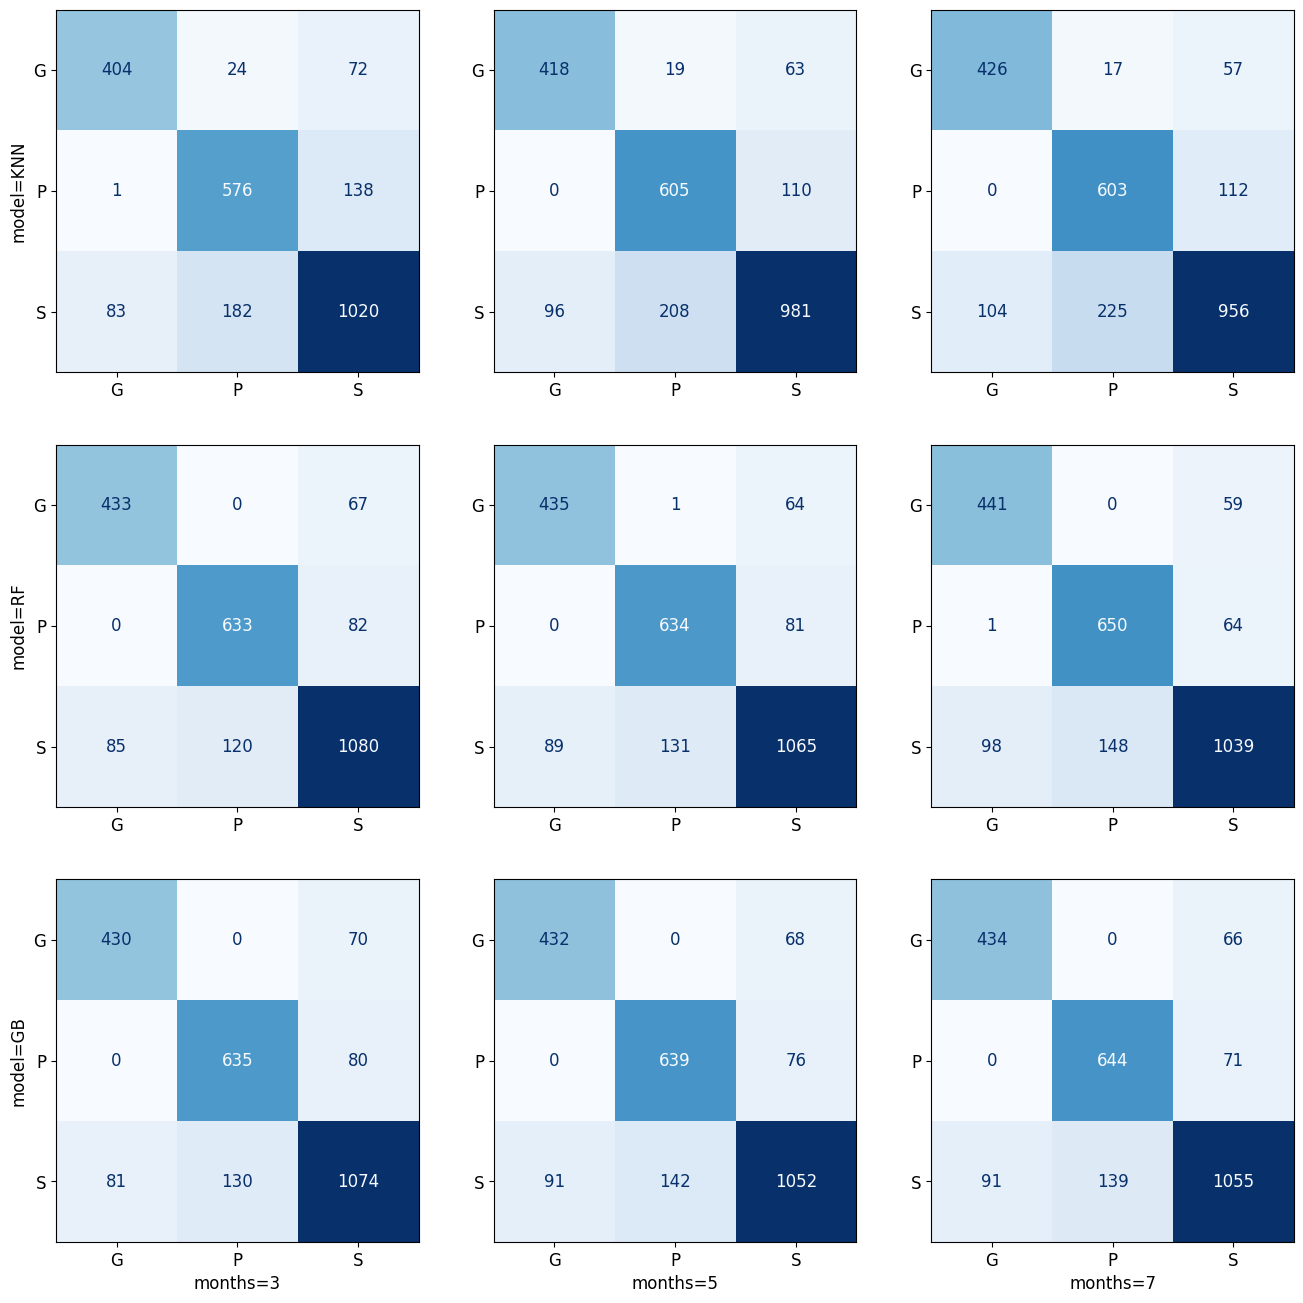

In [30]:
from sklearn import metrics
# Código extraido de https://medium.com/@eceisikpolat/plot-and-customize-multiple-confusion-matrices-with-matplotlib-a19ed00ca16c
plt.rcParams.update({'font.size':12}); display_labels = ["G", "P", "S"]; colorbar = False; cmap = "Blues"; x_labels = [3, 5, 7]; y_labels = ['KNN', 'RF', 'GB']

# Plot confusion matrix
f, axes = plt.subplots(3, 3, figsize=(16, 16))
for i in range(3):
    for j in range(3):
        y_pred = models[j][i]
        #axes[i, j].set_title(f'Accuracy={accuracy_score(y_test, y_pred)}')
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
        metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=display_labels).plot(include_values=True, cmap=cmap, ax=axes[i, j], colorbar=colorbar)
        axes[i, j].set_xlabel(''); axes[i, j].set_ylabel('')

# Set labels
for i in range(len(x_labels)):
    plt.setp(axes[-1, i], xlabel=f'months={x_labels[i]}')
for i in range(len(y_labels)):
    plt.setp(axes[i, 0], ylabel=f'model={y_labels[i]}')

plt.show()
f.savefig("Models_CM.pdf", bbox_inches='tight')